In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.2.1


In [4]:
!ls we

full.csv  OurDataset_test.csv  OurDataset_train.csv


In [5]:
DATA_ROOT = Path("we/")
train = pd.read_csv(DATA_ROOT / 'OurDataset_train.csv')
test = pd.read_csv(DATA_ROOT / 'OurDataset_test.csv')
print(train.shape,test.shape)
train.head()

(14374, 3) (3592, 3)


,label,text,is_valid
0,shunil_gongopaddhay,থেকে কত দূরে চলে এসেছে ভরত। সে হেসে উঠল আপন মন...,False
1,humayun_ahmed,এতে ভয় কমে যায়। বল একটা গল্প।’ ‘তুমি বল।’ আনিস...,False
2,shomresh,হবে। ওই দেখুন ওর এক চোখ কানা। ডান দিকটা দিয়ে দ...,False
3,humayun_ahmed,"বললাম, আপনি ওর গায়ে হাত দিলেন কেন? ষণ্ডাগণ্ডা ...",False
4,humayun_ahmed,হত! আবার চাদর মুড়ি দিয়ে নিজেকে গুটিয়ে ফেলি। যে...,False


In [6]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [7]:
# Parameters
seed = 42
use_fp16 = False
bs = 6

model_type = 'bert'
pretrained_model_name = 'bert-base-multilingual-cased' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [8]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [7]:
# model_class.pretrained_model_archive_map.keys()

In [9]:
torch.cuda.is_available()

True

In [10]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [11]:
seed_all(seed)

In [12]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
# tokenizer_class.pretrained_vocab_files_map

In [15]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [16]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [17]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [18]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
[CLS] ক ##লক ##ার ##খা ##না ? আরও য ##ন্ত ##্র - ন ##ির ##্ ##ভ ##রত ##া ? আরও আর ##াম - [UNK] ? অ ##গ ##্র ##গ ##ম ##ন মা ##নে ক ##ি স ##ম ##কা ##মি ##তা আর ব ##ি ##বা ##হ ব ##র ##্জ ##ন ? অ ##গ ##্র ##গ ##ম ##ন ক ##ি মানু ##ষক ##ে বা ##ঁ ##চ ##তে [UNK] ? অ ##ন ##ু,shirshendu
"[CLS] গ ##ল্প প ##া ##ঠ ##াল ##ে যে ##হ ##ে ##ত ##ু আ ##মি গ ##ল্প ল ##ে ##খ ##ক বলে পরিচিত ন ##ই , আ ##মার গ ##ল্প [UNK] ঠ ##ো ##ঙ ##ার মত ক ##ু ##ঁ ##চ ##কে ফ ##েলে [UNK] [UNK] হ ##াব ##িজ ##ি ##বি ক ##াগ ##জে ##র [UNK] । এর ##শা ##দ ##কে ক ##্ ##ষ ##ম ##তা ##চ ##্য ##ূ ##ত করতে",toslima_nasrin
[CLS] আবার চ ##ল ##তে শুরু ক ##র ##বে । এক প ##থ থেকে আর ##েক প ##থ । অন্য প ##থ ##ের ম ##ো ##ড়ে । [UNK] আ ##হ ##ম ##দ হ ##ো ##সে ##ন তখন ##ো ক ##া ##ঁ ##দ ##ছে । [UNK] দ ##াম [UNK] [UNK] কিছু ##ক্ষণ পরে বা ##ই ##রে [UNK] এ ##লো শ ##ও ##ক ##ত । ল ##ম ##্ব ##া দ ##ে ##হ,zahir_rayhan
"[CLS] [UNK] স ##ি ##গ ##ারে ##ট খা ##চ ##্ ##ছে , প্রকাশ ##্যে ##ই । ধ ##্র ##ু ##ব য ##ত ##দ ##ূ ##র জ ##ানে , [UNK] স ##ি ##গ ##ারে ##ট [UNK] না । এ ##খ ##ন খা ##চ ##্ ##ছে স ##ম ##্ ##ভ ##ব ##ত ভ ##িত ##র ##কার উ ##দ ##্বে ##গ - উ ##ৎ ##ক ##ণ ##্ ##ঠ ##াক ##ে স ##াম ##াল",shirshendu
[CLS] ক ##ি ক ##র ##বে মনে ক ##র ? ক ##ি আ ##মা ##কে আ ##পন ##ি করতে বলে ##ন ? ত ##ো ##মা ##কে ? [UNK] জ ##ী ##বা ##ন ##ন্দ স ##্ত ##ব ##্ধ ন ##তম ##ু ##খে [UNK] ত ##ৈ ##ল ##বি ##র ##ল প ##্র ##দ ##ী ##পের বা ##তি ##টা অ ##কার ##ণ ##ে শ ##ু ##ধ ##ু শ ##ু ##ধ ##ু কে ##বল,shorotchandra


In [20]:
databunch.train_dl.dl.dataset[0][0].text

'[CLS] থেকে ক ##ত দ ##ূ ##রে চলে এ ##সে ##ছে ভ ##রত । সে হ ##েস ##ে উ ##ঠ ##ল আ ##পন মনে । বা ##লিক ##া ব ##ধ ##ূ ##টি ##কে কোন স্কুল ##ে প ##া ##ঠ ##ান ##ো হবে , তা ##ই [UNK] স ##র ##লা ও ব ##ি ##বি ##র মধ্যে ট ##ানা ##টা ##নি শুরু [UNK] গ ##েল । স ##র ##লা [UNK] ব ##ে ##থ ##ুন স্কুল ##ে , ব ##ি ##বি ল ##োর ##েট ##া হ ##া ##উ ##জে । দ ##ু [UNK] জন ##ের ##ই ধ ##ারণ ##া , যার যার ন ##িজের স্কুল ##টি ##ই বেশি ভ ##াল ##ো । ব ##ে ##থ ##ুন স্কুল বা ##ঙ ##াল ##ি [UNK] বাংলা - মা ##ধ ##্য ##ম , আর ল ##োর ##েট ##ো হ ##া ##উ ##জ স ##াহ ##ে ##ব প ##াড়া ##র ইংরেজি স্কুল , সেখানে বা ##ঙ ##াল ##ি ছ ##াত ##্রী ##র [UNK] ফ ##ির ##ি ##ঙ্গ ##ি ছ ##াত ##্রী ##ই বেশি । ব ##ে ##থ ##ুন ##ের অনেক ছ ##াত ##্রী এ ##খ ##ন স ##মা ##জে ##র নাম - করা ম ##হ ##িলা । এই ত ##ো গ ##ত বছর ##েই ব ##ে ##থ ##ুন ##ের একটি ছ ##াত ##্রী ##কে [UNK] হ ##ই ##চ ##ই [UNK] [UNK] । প ##্র ##বেশ ##িকা [UNK] ভ ##াল ##ো ##ভাবে উ ##ত ##্ত ##ীর ##্ণ [UNK] অব ##লা দ ##াস নামে [UNK] ঠ ##িক করে ##ছিল ড ##াক ##্তা ##রি [UNK] । কিন্তু কলকাত

In [21]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([6, 512])
tensor([[  101,   948, 12079,  ..., 22875, 33664,   102],
        [  101,   938, 55077,  ..., 39893, 38044,   102],
        [  101,   100,   969,  ...,   970, 15691,   102],
        [  101, 16869, 53512,  ..., 15215,   920,   102],
        [  101, 18601,   136,  ..., 51003, 71243,   102],
        [  101,   979, 27608,  ...,   970, 69514,   102]])


In [22]:
numtest = test_one_batch[0][:100]
numtest

tensor([   101,    948,  12079,  89362,  18243,    965,  11199,  42651,  53574,
         12235,  26109,    920,    938,  55631,  16755,    974,  16166,  15002,
         36715,  82925,    100,    100, 100024,    100,    100,  28777,  22875,
         39002,    954,  67735,    118,    100,    944,  29993,    970,  29993,
         32294,    920,    937, 111229,  66946,  37289, 111240,  82445,  14176,
         40433,  36715,    948,  27608,  13104,  15002,  53761,  58417,    100,
           938,  55077,  41431,    966,  93168,  12079,    967,  59712,    117,
         52038,  14998,    966, 111238,  11128,  15215, 100840,    970,  29993,
           938,  53574,  12235,    920,  14770,  13104,  15002,    100,    951,
         67366,  12079,    100,  12051,  22904,    978,  65383,    948, 111240,
         29621,  15258,    974,  16166,  72703,    976,  15691, 111240, 103598,
         11421])

In [23]:
numtest[:10].tolist()

[101, 948, 12079, 89362, 18243, 965, 11199, 42651, 53574, 12235]

In [24]:
# "vocab_size": 119547
transformer_tokenizer.decode(numtest.tolist())

'[CLS] কাউকে দেখছি না । আমাদের রুমটা বেশ [UNK] [UNK] সব [UNK] [UNK] একশ জন ছেলে - [UNK] এসে বসেছে । অঙ্ক কম্পিটিশনটা কীরকম হবে সে [UNK] আমার কোন ধারণা নেই, তাই ধৈর্য ধরে বসে আছি । এরকম [UNK] ঘন্টা [UNK] এবং সাথে সাতে ক্লাস রুমের শিক্ষকের'

In [25]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
                
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [26]:
databunch.train_dl.classes

['MZI',
 'bongkim',
 'humayun_ahmed',
 'manik_bandhopaddhay',
 'nazrul',
 'nihar_ronjon_gupta',
 'robindronath',
 'shirshendu',
 'shomresh',
 'shordindu',
 'shorotchandra',
 'shottojit_roy',
 'shunil_gongopaddhay',
 'tarashonkor',
 'toslima_nasrin',
 'zahir_rayhan']

In [27]:
labels = len(databunch.train_dl.classes)
labels

16

In [28]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = labels
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 16,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}



In [29]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [30]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [31]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

(same for bert)
In this case, we can split our model in this way :

In [32]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

Check groups : 

In [33]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(119547, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fe

### Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [39]:
# !mkdir models/aa1

In [40]:
learner.save('aa1/untrain')

In [41]:
seed_all(seed)
learner.load('aa1/untrain');

Therefore, we first freeze all the groups but the classifier with :

In [42]:
learner.freeze_to(-1)

We check which layer are trainable

In [43]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           91,812,096 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

In [44]:
learner.lr_find()

epoch     train_loss  valid_loss  accuracy  time    
0         11.157290   #na#        00:13     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.58E-05


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


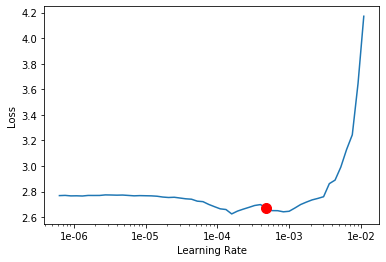

In [45]:
learner.recorder.plot(skip_end=7,suggestion=True)

Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.58E-05


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


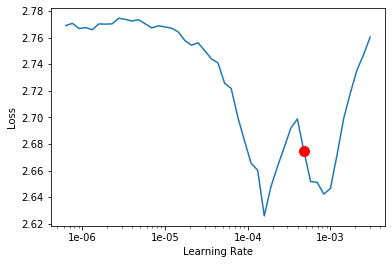

In [46]:
learner.recorder.plot(skip_end=14,suggestion=True)

In [47]:
lr = learner.recorder.min_grad_lr
lr

0.0004786300923226385

We will pick a value a bit before the minimum, where the loss still improves.
Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

In [48]:
learner.fit_one_cycle(5,max_lr=lr,moms=(0.8,0.7))

epoch     train_loss  valid_loss  accuracy  time    
0         1.869246    1.872541    0.382046  05:09     
1         1.510628    1.409339    0.534447  05:10     
2         1.279805    1.372429    0.569937  05:09     
3         1.340494    1.172648    0.611691  05:09     
4         1.139867    1.176096    0.610995  05:10     


In [49]:
learner.save('aa1/fifth_cycle')

In [50]:
learner.freeze_to(-2)

epoch     train_loss  valid_loss  accuracy  time    
0         1.694818    #na#        00:10     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


/home/student_1/.local/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


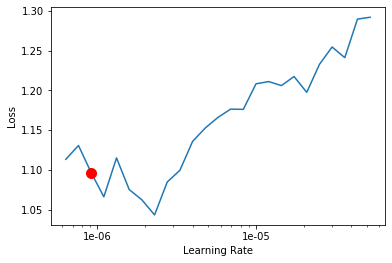

In [51]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

In [52]:
lr = learner.recorder.min_grad_lr
lr

9.120108393559096e-07

In [53]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         1.074048    1.125918    0.636047  05:44     
1         1.102653    1.103620    0.638135  05:45     


In [54]:
learner.save('aa1/seventh_cycle')

In [55]:
seed_all(seed)
learner.load('aa1/seventh_cycle');

In [56]:
learner.freeze_to(-3)

In [57]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         0.982462    1.071483    0.661099  06:28     
1         0.989750    1.026098    0.683368  06:27     


In [58]:
learner.save('aa1/nineth_cycle')

In [59]:
seed_all(seed)
learner.load('aa1/nineth_cycle');

In [60]:
learner.unfreeze()

In [61]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch     train_loss  valid_loss  accuracy  time    
0         0.691139    0.924466    0.705637  14:26     
1         0.607819    0.765149    0.755045  14:26     


In [62]:
learner.save('aa1/eleventh_cycle')

In [65]:
seed_all(seed)
learner.load('aa1/eleventh_cycle');

In [66]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/16th_cycle') ##78--85

epoch     train_loss  valid_loss  accuracy  time    
0         0.524925    0.793026    0.750870  14:22     
1         0.518122    0.587573    0.813500  14:24     
2         0.503640    0.529490    0.834377  14:25     
3         0.348622    0.474804    0.855950  14:26     
4         0.309198    0.488710    0.853862  14:28     


In [67]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/21st_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.464793    0.523459    0.840640  14:26     
1         0.290775    0.507660    0.840640  14:25     
2         0.221737    0.391621    0.884482  14:25     
3         0.235609    0.395680    0.878914  14:25     
4         0.220904    0.367843    0.887265  14:25     


In [68]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/26th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.218173    0.437637    0.862909  14:25     
1         0.241426    0.399211    0.879610  14:26     
2         0.170548    0.311558    0.908142  14:26     
3         0.141434    0.314918    0.903967  14:27     
4         0.160381    0.297051    0.908142  14:27     


In [69]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/30th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.125065    0.304410    0.910926  14:26     
1         0.134035    0.329924    0.905358  14:26     
2         0.083073    0.264938    0.917884  14:27     
3         0.080816    0.281153    0.913709  14:27     
4         0.108152    0.259635    0.915101  14:27     


In [70]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/35th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.105410    0.269674    0.914405  14:26     
1         0.095276    0.345360    0.906054  14:26     
2         0.101761    0.294705    0.911621  14:27     
3         0.060816    0.221886    0.932498  14:26     
4         0.041902    0.226261    0.931106  14:26     


In [71]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('aa1/40th_cycle')

epoch     train_loss  valid_loss  accuracy  time    
0         0.092591    0.246650    0.924148  14:23     
1         0.104496    0.202555    0.938065  14:26     
2         0.058693    0.227357    0.932498  14:27     
3         0.062887    0.211304    0.934586  14:25     
4         0.022956    0.194777    0.942937  14:25     


### Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

In [72]:
def testing(df):
    text_array = df["text"].tolist()
    print(len(text_array))

    final_preds = []

    for text in text_array:
      preds = learner.predict(text)
      final_preds.append(str(preds[0]))

    targets = df["label"].tolist()

    err=[]
    count =0;
    tst = len(text_array)

    for i in range(tst):
        if(targets[i]==final_preds[i]):
          count = count+1
        else:
          err.append((targets[i],final_preds[i]))
    print("Accuracy: ")
    print(count/tst)
    print(err)

    return final_preds,targets

In [73]:
pred,targ = testing(test)

3592
Accuracy: 
0.9479398663697105
[('shunil_gongopaddhay', 'shottojit_roy'), ('shunil_gongopaddhay', 'humayun_ahmed'), ('shomresh', 'MZI'), ('toslima_nasrin', 'manik_bandhopaddhay'), ('shirshendu', 'shunil_gongopaddhay'), ('shordindu', 'robindronath'), ('shottojit_roy', 'MZI'), ('robindronath', 'bongkim'), ('shomresh', 'shirshendu'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'MZI'), ('shirshendu', 'shottojit_roy'), ('shordindu', 'nihar_ronjon_gupta'), ('shordindu', 'MZI'), ('bongkim', 'shorotchandra'), ('manik_bandhopaddhay', 'MZI'), ('humayun_ahmed', 'toslima_nasrin'), ('robindronath', 'nazrul'), ('humayun_ahmed', 'MZI'), ('nihar_ronjon_gupta', 'MZI'), ('manik_bandhopaddhay', 'toslima_nasrin'), ('shorotchandra', 'robindronath'), ('tarashonkor', 'nihar_ronjon_gupta'), ('shordindu', 'tarashonkor'), ('nihar_ronjon_gupta', 'shunil_gongopaddhay'), ('nazrul', 'toslima_nasrin'), ('shirshendu', 'shomresh'), ('robindronath', 'shordindu'), ('manik_bandhopaddhay', 'MZI'), ('shomres

## Conclusion

In this NoteBook, I explain how to combine the ``transformers`` library with the beloved ``fastai`` library. It aims to make you understand where to look and modify both libraries to make them work together. Likely, it allows you to use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and even **Gradual Unfreezing**. As a result, without even tunning the parameters, you can obtain rapidly state-of-the-art results.

This year, the transformers became an essential tool to NLP. Because of that, I think that pre-trained transformers architectures will be integrated soon to future versions of fastai. Meanwhile, this tutorial is a good starter.

I hope you enjoyed this first article and found it useful. 
Thanks for reading and don't hesitate in leaving questions or suggestions.


## References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)